# Assignment 3
**Group 5**

Group members:
- Moqian Chen (r0965473)
- Laurens Dergent (r0794288)
- Sarah Guilliams (r0751825)
- Yeabsera Kinfu (r0930148)
- Jorge Puertolas Molina (r0978889)
- Isabel Scholz (r1008561)

Link to the GitHub repository: https://github.com/LaurensDergent/DataAnalytics.git 

## 1. Spark setting and data import

The task is about streaming analysis, as well as text analysis, building machine learning models specifically with PySpark streaming context and MLBib. The data collected are from a Spark setting. The gathered data contained 6600 instances that spread over 3 weeks, from the 14th of April to the 12th of May. After duplicate removal, there were 5700 entries in the data set, which is large enough for a machine-learning model on text analysis. The data then went through several more processing steps that will be explained one by one throughout the notebook.

In the model experimentation/selection section, there are 2 steps, one where we run the models using TF-IDF, and one where we run the models using Word2Vec and LDA Topic Modelling. This has an explanation. In the beginning, the goal was to encode the source text using TF-IDF. The reasoning behind this was to obtain relationships between word incidence and whether an article will end up on the frontpage. We thought that the inclusion of the IDF factor would highlight niche words in each article much more, and we would be able to infer useful connections between a word, and the likelihood that the article the word was in would be popular. This assumption was wrong, and the models performed horribly on TF-IDF, especially Naive Bayes. For this reason, we decided to seek solutions in other methods. Latent Dirichtlet Allocation and Word2Vec seemed like good options because they didn’t produce highly dimensional data, and captured denser, richer contextual information than TF-IDF. The code for these methods is presented earlier than the use of them.

The last section of the assignment focuses on model deployment. Out of all tested models, the best one is stored. The best model had to contain numerical text representations since we had to process the text later in the deployment. The best out of the ones with numerical text representations was chosen. Later, in the deployment section, the incoming data is preprocessed and predicted.

In [1]:
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, ArrayType
from pyspark.sql import Row, SparkSession
from pyspark.ml.classification import LogisticRegression, NaiveBayes

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler, HashingTF, IDF, Word2Vec, Normalizer, MinMaxScaler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import LDA
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import PorterStemmer
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from pyspark.sql.functions import udf, struct, array, col, lit
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.classification import NaiveBayesModel
import warnings
warnings.filterwarnings("ignore")

In [2]:
spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [3]:
from pyspark.shell import sc
sc

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/

Using Python version 3.8.19 (default, Mar 20 2024 19:55:45)
Spark context Web UI available at http://192.168.1.14:4045
Spark context available as 'sc' (master = local[*], app id = local-1716726499182).
SparkSession available as 'spark'.


<SparkContext master=local[*] appName=PySparkShell>

In [4]:
spark

In [5]:
# Read through all the subdirectories saved
df = spark.read.json("./data")

## 2. Preprocessing

Several processing steps were needed to prepare the Spark Dataframe for model training.

### Removing duplicates

After duplicate removal, there were around 5700 entries in the data set, which is large enough for a machine-learning model on text analysis.

In [6]:
# Remove duplicate rows and count
df = df.dropDuplicates()
df.count()

5753

In [7]:
schema = StructType([
    StructField("aid", StringType(), True),
    StructField("title", StringType(), True),
    StructField("url", StringType(), True),
    StructField("frontpage", StringType(), True),
    StructField("source_text", StringType(), True),
        StructField("votes", IntegerType(), True),
    StructField("comments", IntegerType(), True),

        StructField("domain", StringType(), True),
        StructField("user", StringType(), True),
    StructField("posted_at", StringType(), True),
        StructField("source_title", StringType(), True)
])


# Parse the JSON strings using the defined schema
df = df.withColumn("parsed_value", from_json(col("value"), schema)).select("parsed_value.*")

# Show the DataFrame with all columns
df.show(5)

+--------+--------------------+--------------------+---------+--------------------+-----+--------+-----------------+---------+-------------------+--------------------+
|     aid|               title|                 url|frontpage|         source_text|votes|comments|           domain|     user|          posted_at|        source_title|
+--------+--------------------+--------------------+---------+--------------------+-----+--------+-----------------+---------+-------------------+--------------------+
|40364744|A design for micr...|https://www.nextb...|    false|Millimeter accura...|    1|       0|nextbigfuture.com|    fanf2|2024-05-15 09:24:02|Millimeter accura...|
|40133032|Unreal Engine 5.4...|https://dev.epicg...|    false|Unreal Engine 5.4...|    1|       0|    epicgames.com|makepanic|2024-04-23 15:27:19|Unreal Engine 5.4...|
|40206221|Sunlight and Vita...|https://www.ncbi....|     true|Sunlight and Vita...|   43|      42|          nih.gov|      luu|2024-04-30 01:10:50|Sunlight and V

In [8]:
df = df.withColumn('frontpage', when(df.frontpage==True, 1).otherwise(0))

In [9]:
df.show()

+--------+--------------------+--------------------+---------+--------------------+-----+--------+--------------------+-------------+-------------------+--------------------+
|     aid|               title|                 url|frontpage|         source_text|votes|comments|              domain|         user|          posted_at|        source_title|
+--------+--------------------+--------------------+---------+--------------------+-----+--------+--------------------+-------------+-------------------+--------------------+
|40364744|A design for micr...|https://www.nextb...|        0|Millimeter accura...|    1|       0|   nextbigfuture.com|        fanf2|2024-05-15 09:24:02|Millimeter accura...|
|40133032|Unreal Engine 5.4...|https://dev.epicg...|        0|Unreal Engine 5.4...|    1|       0|       epicgames.com|    makepanic|2024-04-23 15:27:19|Unreal Engine 5.4...|
|40206221|Sunlight and Vita...|https://www.ncbi....|        1|Sunlight and Vita...|   43|      42|             nih.gov|      

### Order Data

The data was ordered to ensure that future data wasn't being used to predict past data.

In [10]:
# Sort by Time in ascending order
df_sorted = df.orderBy("posted_at")

In [11]:
df_sorted.show()

+--------+--------------------+--------------------+---------+--------------------+-----+--------+-----------------+---------------+-------------------+--------------------+
|     aid|               title|                 url|frontpage|         source_text|votes|comments|           domain|           user|          posted_at|        source_title|
+--------+--------------------+--------------------+---------+--------------------+-----+--------+-----------------+---------------+-------------------+--------------------+
|40038747|Le Rôle de l'IA d...|https://www.rubyb...|        0|[HORS SÉRIE #6] T...|    1|       0|   rubybiscuit.fr|         dom_fr|2024-04-15 10:39:26|[HORS SÉRIE #6] T...|
|40038755|After delay due t...|https://www.there...|        0|Ubuntu 24.04 'Nob...|    1|       0|  theregister.com|        lproven|2024-04-15 10:40:57|Ubuntu 24.04 'Nob...|
|40038759|Weird monitor bug...|https://notes.ali...|        0|Weird monitor bug...|    1|       0| alinpanaitiu.com|          fanf

### Select necessary variables

Some columns that were not useful in the prediction task were dropped. For columns like user, aid, url, posted_at and domain, they are of no use because they are too unique. There are two 'titles' for each article: 'title' and 'source_title'. Only 'title' was kept considering the fact that people would browse Hacker News  based on titles instead of source titles.

In [12]:
# Keep necessary columns ('source_title', 'frontpage', 'comments', 'votes', 'domain', 'posted_at') and show the transformed dataframe for check

df_sorted = df_sorted.select(col('comments'), col('frontpage'), col('source_text'), col('votes'))

### Removing missing values

Missing values are detected and dropped as well. As inspected, there are two kinds of missing values. One type is 'NULL' contents. Another one is '404 error' (shown as `Page not found').

In [13]:
# Missing values check: 2 types could be viewed as missing values, then count
# Type 1: Page not found
# Type 2: NULL
df_sorted = df_sorted.where(df.source_text != 'Page not found')
df_sorted.dropna()
df_sorted.count()

5696

### Encoding the label column

The label frontpage was transformed to a binary variable, where cases for which frontpage was equal to true were treated as positive, and on the contrary, articles that did not end up on the frontpage, were treated as negative.

In [14]:
# Encode the label column 'frontpage' and show it to verify
df_sorted = df_sorted.withColumn('frontpage', when(df.frontpage==True, 1).otherwise(0))
df_sorted.show()

+--------+---------+--------------------+-----+
|comments|frontpage|         source_text|votes|
+--------+---------+--------------------+-----+
|       0|        0|[HORS SÉRIE #6] T...|    1|
|       0|        0|Ubuntu 24.04 'Nob...|    1|
|       0|        0|Weird monitor bug...|    1|
|       0|        0|SQL Optimizations...|    2|
|       0|        0|The Worst Product...|    1|
|       0|        0|The security impl...|    2|
|       0|        0|GitHub - soywod/n...|    1|
|       0|        0|Filesystem error ...|    2|
|       0|        0|OpenRazer 3.8 Bri...|    2|
|       0|        0|GitHub - sjurba/r...|    2|
|       0|        0|How Perfectly Can...|    2|
|       6|        1|Are Flying Cars F...|    8|
|       0|        0|GCC version 14 co...|    1|
|       0|        0|Malleable softwar...|    2|
|       0|        0|Research finds Am...|    2|
|       0|        0|Cammy/Bikeshed - ...|    1|
|       0|        0|RVBBIT\n\n🔥 Firs...|    1|
|       0|        0|Argentina's Javie...|

### Removing punctuations, stopwords and tokenizing the text

In preparation of featurization, the 'source_text' variable is tokenized so that sentences could be sliced into single words. After
tokenization, punctuations and stopwords have been removed.

In [15]:
# For text, remove the punctuations ('/"/,/./:/-/?/!/:/|/[/])
from pyspark.sql.functions import *

df_punc_drop = df_sorted.withColumn('source_text', regexp_replace(df.source_text, '[^a-zA-Z0-9]', ' '))

In [16]:
# For text, make every word in lowercase
from pyspark.ml.feature import Tokenizer

df_token = Tokenizer(inputCol="source_text", outputCol="tokens").transform(df_punc_drop)
df_token.show()

+--------+---------+--------------------+-----+--------------------+
|comments|frontpage|         source_text|votes|              tokens|
+--------+---------+--------------------+-----+--------------------+
|       0|        0| HORS S RIE  6  T...|    1|[, hors, s, rie, ...|
|       0|        0|Ubuntu 24 04  Nob...|    1|[ubuntu, 24, 04, ...|
|       0|        0|Weird monitor bug...|    1|[weird, monitor, ...|
|       0|        0|SQL Optimizations...|    2|[sql, optimizatio...|
|       0|        0|The Worst Product...|    1|[the, worst, prod...|
|       0|        0|The security impl...|    2|[the, security, i...|
|       0|        0|GitHub   soywod n...|    1|[github, , , soyw...|
|       0|        0|Filesystem error ...|    2|[filesystem, erro...|
|       0|        0|OpenRazer 3 8 Bri...|    2|[openrazer, 3, 8,...|
|       0|        0|GitHub   sjurba r...|    2|[github, , , sjur...|
|       0|        0|How Perfectly Can...|    2|[how, perfectly, ...|
|       6|        1|Are Flying Car

In [17]:
# For text, remove stop words (a/an/the/then/and...)
from pyspark.ml.feature import StopWordsRemover

stopwords = StopWordsRemover()
stopwords.getStopWords()

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [18]:
stopwords = stopwords.setInputCol('tokens').setOutputCol('words')
df_clean = stopwords.transform(df_token)
df_clean.show()

+--------+---------+--------------------+-----+--------------------+--------------------+
|comments|frontpage|         source_text|votes|              tokens|               words|
+--------+---------+--------------------+-----+--------------------+--------------------+
|       0|        0| HORS S RIE  6  T...|    1|[, hors, s, rie, ...|[, hors, rie, , 6...|
|       0|        0|Ubuntu 24 04  Nob...|    1|[ubuntu, 24, 04, ...|[ubuntu, 24, 04, ...|
|       0|        0|Weird monitor bug...|    1|[weird, monitor, ...|[weird, monitor, ...|
|       0|        0|SQL Optimizations...|    2|[sql, optimizatio...|[sql, optimizatio...|
|       0|        0|The Worst Product...|    1|[the, worst, prod...|[worst, product, ...|
|       0|        0|The security impl...|    2|[the, security, i...|[security, implic...|
|       0|        0|GitHub   soywod n...|    1|[github, , , soyw...|[github, , , soyw...|
|       0|        0|Filesystem error ...|    2|[filesystem, erro...|[filesystem, erro...|
|       0|

## More processing: Feature Engineering and Oversampling

### Normalization

Comments and votes needed to be normalized for the logistic regression model. Without normalization, the logistic regression was always
predicting a 0 (i.e., that the story does not end on the frontpage). This could be explained by the fact that the extreme values were setting the threshold for 1 (i.e., that the story ends on the frontpage) very high due to the low coefficients.

In [19]:
def normalization(df, inputCols):
    assembler = VectorAssembler(
        inputCols=inputCols,
        outputCol="comvot"
    )

    assembled_df = assembler.transform(df)
    # Initialize Normalizer
    normalizer = Normalizer(inputCol="comvot", outputCol="norm_comvot", p=2.0)

    # Normalize the data
    df = normalizer.transform(assembled_df)
    return df

### Oversampling

Positive cases are so few that models could be unable to fully learn the patterns, the ratio of negative to positive cases is 4.5. To solve class imbalance, oversampling was used. The method used for oversampling is sampling with replacement.

In [20]:
print('Count of negative cases:', df_clean.select('frontpage').where(df_clean.frontpage==0).count())
print('Count of positive cases:', df_clean.select('frontpage').where(df_clean.frontpage==1).count())

Count of negative cases: 4671
Count of positive cases: 1025


In [21]:
def oversample_minority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter("frontpage=1").count()
    majority_count = df.filter("frontpage=0").count()
    
    balance_ratio = majority_count / minority_count
    
    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
    if ratio >= balance_ratio:
        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
    else:
        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
    
    oversampled_minority = df.filter("frontpage=1")\
                                .sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
    oversampled_df = df.filter("frontpage=0").union(oversampled_minority)
    
    return oversampled_df

### TF-IDF

In [22]:
def tf_idf(df, colwords):
# Step 1: Compute TF
    hashing_tf = HashingTF(inputCol= colwords, outputCol="tf_features", numFeatures=custom_params["tf_idf"])
    tf_data = hashing_tf.transform(df)

    # Step 2: Compute IDF
    idf = IDF(inputCol="tf_features", outputCol="tfidf_features")
    idf_model = idf.fit(tf_data)
    df = idf_model.transform(tf_data)
    return df

### Word2Vec

Word2Vec creates a vector space for the corpus. The size of the vector specifies how many axies the space has. Each word would get a score vector with one score on one axis. The vector of the document, in the end, is one with average values of all the vectors for single words. Then, any document from the corpus would get a coordinate in the space, represented by the vector. In the end, the feature vectors would merely contain much less features without losing any information. Besides, since it is a coordinate, relationships between single words are considered. This attribute complements an obvious shortcoming of TF-IDF other than high dimensionality: context of a document.


In [24]:
def word2vecproc(train, colwords, vecsize):
    word2Vec = Word2Vec(vectorSize=vecsize, minCount=0, inputCol=colwords, outputCol="w2vfeatures")
    word2vec_model = word2Vec.fit(train)
    train = word2vec_model.transform(train)

    rescaler = MinMaxScaler(min = 0, max = 1, inputCol = 'w2vfeatures', outputCol='w2vfeatures_rescaled')
    rescale = rescaler.fit(train)
    train = rescale.transform(train)
    return train 

### LDA (LATENT DIRICHTLET ALLOCATION)

LDA is another appraoch to reduce dimensions of the feature column. The reduction is similar with what Word2Vec does. However, instead of considering context, LDA considers topics. It assumes there are some common topics in the corpus. And the vector of each document would indicate how far it is from a certain latent topic.

In [23]:
def lda_met(train, colwords, ntopics):
    vectorizer = CountVectorizer(inputCol=colwords, outputCol="counts")
    vectorizer_model = vectorizer.fit(train)
    bow_df = vectorizer_model.transform(train_processed)

    # Train the LDA model
    num_topics = ntopics 
    lda = LDA(k=num_topics, maxIter=10, featuresCol="counts")
    lda_model = lda.fit(bow_df)
    train = lda_model.transform(bow_df)
    return train

### Train/Test Split

The train/test data split is done in chronological order, so that the first 75 % of the data is the train set, and the last 25% is the test set.

In [25]:
def traintestsplit(df_final):
    # Select relevant columns for the model
    df_final = df_final.select("features", "frontpage")

    # Count the total number of rows
    total_count = df_final.count()
    train_count = int(total_count * 0.75)
    test_count = total_count - train_count

    # Select the first 80% of the rows for the training set
    train = df_final.limit(train_count)

    # Select the remaining 20% of the rows for the test set
    test = df_final.subtract(train).limit(test_count)

    return train, test

## MODEL EXPERIMENTATION/SELECTION

Before starting with the model experimentation, a function was created that gathers the right data based on the input preferences for feature engineering.

In [26]:
def gather_features(df, model_params, classifier):
    input_cols = []
    for key, value in model_params.items():
        if value == 1:
            if key == "tf_idf":
                input_cols.append("tfidf_features")
            elif key == "comvot":
                if classifier == "LogReg":
                    input_cols.append("norm_comvot")
                else:
                    input_cols.append("comments")
                    input_cols.append("votes")
            elif key == "Topic_modelling":
                input_cols.append("topicDistribution")
            elif key == "word2vec":
                input_cols.append("w2vfeatures_rescaled")

    assembler = VectorAssembler(inputCols= input_cols, outputCol="features")
    df_final = assembler.transform(df)
    return df_final

### MODELS

Below, functions are defined to fit the NaiveBayes and the Logistic Regression.

#### NaiveBayes

In [27]:
def NaiveBayesOwn(train):
    nb = NaiveBayes(modelType="multinomial", labelCol="frontpage")
    model = nb.fit(train)
    return model

#### Logistic Regression

In [28]:
def LogReg(train):
    # Create a LogisticRegression instance. This instance is an Estimator.
    lr = LogisticRegression(maxIter=10, featuresCol = "features", labelCol = "frontpage")

    # Fit the model to the training data
    model = lr.fit(train)
    return model

### PART 1: TF-IDF

In [29]:
first_time = True

To facilitate the comparison of various models, we designed a framework that enabled us to customize the preprocessing techniques and model parameters. The methodology involves creating the model with the desired inputs, computation of metrics, and addition of results to the table. With this approach we can systematically evaluate the impact of different preprocessing methods and parameters on model performance, helping us choose the best combination.

In [32]:
model_params = {"tf_idf" : 1, "comvot": 1, "oversampling" : 1}
custom_params = {"tf_idf" : 10,"comvot" : "", "oversampling": ""}
classifier = "NaiveBayes"
train_processed = df_clean

#### Processing Pipeline and training

In [31]:
if model_params["tf_idf"] == 1:
    train_processed = tf_idf(train_processed, "words")
if classifier == "LogReg":
    train_processed = normalization(train_processed, ["comments", "votes"])

train_processed = gather_features(train_processed, model_params, classifier)
train, test = traintestsplit(train_processed)
if model_params["oversampling"] == 1:
    train = oversample_minority(train)

if classifier == "NaiveBayes":
    model = NaiveBayesOwn(train)
elif classifier == "LogReg":
    model = LogReg(train)

Initial Majority:Minority ratio is 4.88:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


#### Prediction and Evaluation

In [32]:
# Make Predictions
predictions = model.transform(test)
predictions.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------+-------------------------------------------+----------+
|features                                                                                                                                                                                                      |frontpage|rawPrediction                            |probability                                |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------+-------------------------------------------+----------+
|[0.17868615809867577,0.2924250375691107,0.323169020

24/05/26 13:38:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [33]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy:.2f}")

Test set accuracy = 0.71


The final analysis for deciding which one of the models will be used, will mostly be based on the TPR, since this is the most crucial aspect for the project. It is not important to predict that an article will not end up on the frontpage well, the crucial part is making sure the frontpages are predicted well.

In [34]:
true_positive = predictions.filter((col("prediction") == 1) & (col("frontpage") == 1)).count()
false_negative = predictions.filter((col("prediction") == 0) & (col("frontpage") == 1)).count()

In [35]:
if (true_positive + false_negative) > 0:
    tpr = true_positive / (true_positive + false_negative)
else:
    tpr = 0.0  # Handle the case when there are no positive samples in the data

print(f"True Positive Rate (TPR): {tpr}")

True Positive Rate (TPR): 0.6506849315068494


#### Table of Results

In [36]:
# Define the row to add
model_name = classifier
for key, value in model_params.items():
    if value == 1:
        model_name = model_name + "+" + key + str(custom_params[key])

schema = StructType([
    StructField("Model", StringType(), True),
    StructField("Accuracy", DoubleType(), True),
    StructField("TPR", DoubleType(), True)
])
# Create a DataFrame with the new row
new_row = spark.createDataFrame([Row(Model=model_name, Accuracy=accuracy, TPR=tpr)], schema)

In [37]:
if first_time == True:
    # Create an empty DataFrame
    empty_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
    updated_df = empty_df.union(new_row)
    first_time = False
else:
    updated_df = updated_df.union(new_row)

In [38]:
updated_df.show(truncate = False)

+---------------------------------------+-----------------+------------------+
|Model                                  |Accuracy         |TPR               |
+---------------------------------------+-----------------+------------------+
|NaiveBayes+tf_idf10+comvot+oversampling|0.710960960960961|0.6506849315068494|
+---------------------------------------+-----------------+------------------+



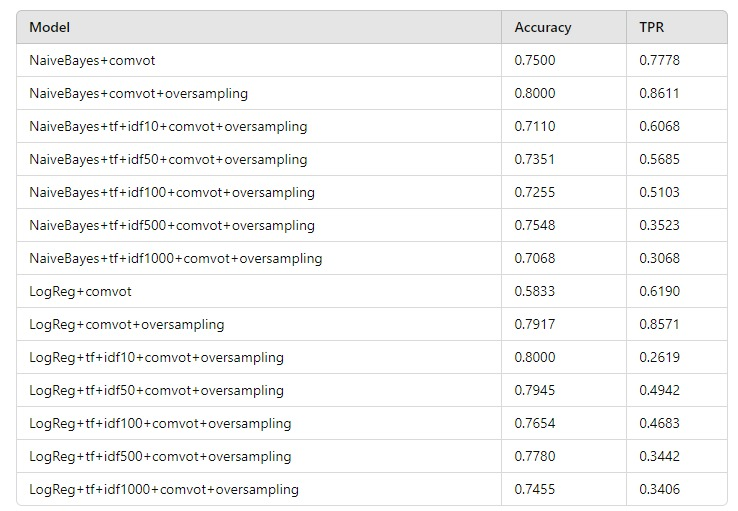

In [11]:
from IPython.display import Image

# Load and display the image
Image(filename='Assignment_3_Image_1.jpg')

The first model that was developed was the NaiveBayes with variables comments and votes, which served as the baseline model. This model returned an accuracy of 0.75, and a TPR of 0.78, which was more than expected. Later, the idea for expanding the model included oversampling. After running the baseline model with oversampling, this improved both accuracy and TPR, increasing to 0.8 and 0.86 each. This suggests oversampling really helped in predicting positives well. The next step was adding TF-IDF counts as input features. After running models with increasing TF-IDF features, starting from 10 and ending in 1000, it can be observed that the more the TF-IDF features are included, the lower the TPR. It starts with a TPR of 0.65 for 10 TF-IDF features, which is already a huge decrease, and it ends up at a worrying TPR of 0.3.The decrease in true positive rate (TPR) as more TF-IDF features are input into a NaiveBayes model can be traced back to the independence assumption in NaiveBayes classifiers. NaiveBayes assumes that all features (words, in this case) are independent given the class label. This means it treats the presence or absence of each word in isolation.

However, this is a strong assumption and often not true in real-world text data, where the combination of words (context) is important. In reality, the relationship between a specific word and whether an article will end up on the front page or not is likely to have very little correlation. It is unlikely that a unique word on its own can determine this outcome.

When the NaiveBayes model multiplies all these small probabilities for each word occurring independently, it often results in extremely small values. This can bias the classifier towards predicting the majority class (often 0), thereby reducing the number of true positives.

For Logistic regression the same building model process was used, with the slight difference that normalization had to be applied, because the majority of the model's predictions were 0. The baseline Logistic Regression showed worse results than the baseline Naive Bayes, with an accuracy of 0.58 and a TPR of 0.62. The Logistic regression model with oversampling improves a lot and is almost as good as the Naive Bayes with oversampling. For the TF-IDF effect on Logistic Regression, we get almost the same results as for the Naive Bayes. The best model after running Logistic Regressions and Naive Bayes' with oversampling and TF-IDF, is the baseline Naive Bayes model with oversampling. This means that the best model does not make use of textual data, which is a shame, since this data could potentially be very useful. As a result, more dense representations (lower dimensionality) of the context were needed, and compared to TF-IDF, Word2Vec considers the relationship between words. It is also cost-efficient in calculation, unlike TF-IDF, which causes our computers to crash. Topic-modelling using Latent Dirichtlet Allocation was also added, since it was hypothesized that certain topics could definitely have a higher popularity and result in a higher ratio of frontpage articles (e.g AI currently, bitcoin 5 years ago, etc).

### PART 2: Word2Vec and LDA

In [39]:
first_time = True

In [40]:
model_params = {"Topic_modelling": 0, "word2vec" : 1, "comvot" : 1, "oversampling" : 1}
custom_params = {"Topic_modelling" : 3, "word2vec" : 5, "comvot" : "", "oversampling": ""}
classifier = "LogReg"
train_processed = df_clean

#### Processing Pipeline and training

In [41]:
if model_params["Topic_modelling"] == 1:
    train_processed = lda_met(train_processed, "words", custom_params["Topic_modelling"])
if model_params["word2vec"] == 1:
    train_processed = word2vecproc(train_processed, "words", custom_params["word2vec"])
if classifier == "LogReg":
    train_processed = normalization(train_processed, ["comments", "votes"])

train_processed = gather_features(train_processed, model_params, classifier)
train, test = traintestsplit(train_processed)
if model_params["oversampling"] == 1:
    train = oversample_minority(train)

if classifier == "NaiveBayes":
    model = NaiveBayesOwn(train)
elif classifier == "LogReg":
    model = LogReg(train)

Initial Majority:Minority ratio is 4.88:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


#### Prediction and Evaluation

In [42]:
# Make Predictions
predictions = model.transform(test)
predictions.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------+---------+------------------------------------------+-----------------------------------------+----------+
|features                                                                                                                               |frontpage|rawPrediction                             |probability                              |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+---------+------------------------------------------+-----------------------------------------+----------+
|[0.7710486538347004,0.9462704667386957,0.225409274098229,0.9933298658271144,0.07910426463851522,0.0,1.0]                               |1        |[0.13520491134802626,-0.13520491134802626]|[0.5337498302179107,0.46625016978208933] |0.0       |
|[0.5772420746471496,0.4

In [43]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy:.2f}")

Test set accuracy = 0.84


The final analysis for deciding which of the models will be used, will mostly be based on the tpr, since this is the most crucial aspect for the project. It is not important predicting that an article will not end up on the frontpage well, the crucial part is making sure the frontpages are predicted well.

In [44]:
true_positive = predictions.filter((col("prediction") == 1) & (col("frontpage") == 1)).count()
false_negative = predictions.filter((col("prediction") == 0) & (col("frontpage") == 1)).count()

In [45]:
if (true_positive + false_negative) > 0:
    tpr = true_positive / (true_positive + false_negative)
else:
    tpr = 0.0  # Handle the case when there are no positive samples in the data

print(f"True Positive Rate (TPR): {tpr}")

True Positive Rate (TPR): 0.26811594202898553


#### Table of Results

In [46]:
# Define the row to add
model_name = classifier
for key, value in model_params.items():
    if value == 1:
        model_name = model_name + "+" + key + str(custom_params[key])

schema = StructType([
    StructField("Model", StringType(), True),
    StructField("Accuracy", DoubleType(), True),
    StructField("TPR", DoubleType(), True)
])
# Create a DataFrame with the new row
new_row = spark.createDataFrame([Row(Model=model_name, Accuracy=accuracy, TPR=tpr)], schema)

In [47]:
if first_time == True:
    # Create an empty DataFrame
    empty_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
    updated_df2 = empty_df.union(new_row)
    first_time = False
else:
    updated_df2 = updated_df2.union(new_row)

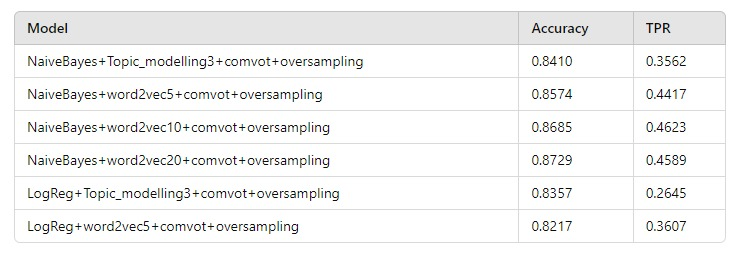

In [12]:
# Load and display the image
Image(filename='Assignment_3_Image_2.jpg')

The models tried in this second part (Word2Vec, topic modelling) seem to improve accuracy, but the TPR is far from desired. For Naive Bayes, Topic Modelling shows a very low TPR of 0.35, while Word2Vec embeddings show an impressive accuracy of 0.87 but a low tpr of 0.46. Different sizes of Word2Vec embeddings were tried, and higher dimensional ones seem to yield a better result. For Logistic Regression, the results were worse than the NaiveBayes, both in tpr and accuracy, for both Word2Vec and topic modelling. Both techniques couldn't be combined together, this caused the pc to crash. 

In summary, it was difficult to further develop and improve the models that we built. This was mainly due to the fact that our laptops could not handle the training of these models. Something that we wanted to do, but could not due to limited computational power is perform hyperparameter tuning of the number of Word2Vec embeddings and the number of topics in LDA.

Other future work involved including title and domain data. The title could have been a useful variable. People mainly click articles because of attractive titles. It was hard to devise a strategy to quantify this attractiveness. Bert models could have been very useful in our case, to extract these types of patterns from embeddings. Different variants of models like XGBoost and RandomForest could also have been used.


### Final Model Selection

For deployment, the chosen model was the best model out of the models with numerical text representations. This was the NaiveBayes with oversampling and 10 TF-IDF counts, that exhibited a TPR of 0.61.

In [33]:
model_params = {"tf_idf" : 1, "comvot": 1, "oversampling" : 1}
custom_params = {"tf_idf" : 10,"comvot" : "", "oversampling": ""}
classifier = "NaiveBayes"

if model_params["tf_idf"] == 1:
    train_processed = tf_idf(train_processed, "words")
train_processed = gather_features(train_processed, model_params, classifier)
train, test = traintestsplit(train_processed)
train = oversample_minority(train)

Initial Majority:Minority ratio is 4.88:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


In [34]:
nb = NaiveBayes(featuresCol='features', modelType="multinomial", labelCol="frontpage")
nbm = nb.fit(train_processed)

In [35]:
# Save the model to the local file, please define own local directory here

model_path = './models/naive_bayes_finalmodel'
naive_bayes_final = nbm.save(model_path)

## Model deployment

There are two goals:
(1) save the model;
(2) preprocessing the incoming message.
At first, a threading is added as a helper thread to avoid the Spark StreamingContext from blocking Jupyter. Then, the steps from preprocessing are repeated so that newly coming data would de decomposited into tokens first and quantitative features in the end. After that, the model would understand the features from the new entries. We fit the transformers on the original data set. So the transformers would comprehend the new entries based on the vocabulary from the original train set. Hence, we do not add new entries to the original data set and refit the transformers. New words from new texts would get ignored.

In [36]:
import threading
        
class StreamingThread(threading.Thread):
    def __init__(self, ssc):
        super().__init__()
        self.ssc = ssc
    def run(self):
        self.ssc.start()
        self.ssc.awaitTermination()
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

In [39]:
hashing_stream = HashingTF(inputCol= 'words', outputCol="tf_features", numFeatures=10)
tf_data = hashing_stream.transform(df_clean)

idf_stream = IDF(inputCol="tf_features", outputCol="tfidf_features")
idf_model_stream = idf_stream.fit(tf_data)
df_tfidf = idf_model_stream.transform(tf_data)
df_tfidf.show(5)

+--------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|comments|frontpage|         source_text|votes|              tokens|               words|         tf_features|      tfidf_features|
+--------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       0|        0| HORS S RIE  6  T...|    1|[, hors, s, rie, ...|[, hors, rie, , 6...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|
|       0|        0|Ubuntu 24 04  Nob...|    1|[ubuntu, 24, 04, ...|[ubuntu, 24, 04, ...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|
|       0|        0|Weird monitor bug...|    1|[weird, monitor, ...|[weird, monitor, ...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|
|       0|        0|SQL Optimizations...|    2|[sql, optimizatio...|[sql, optimizatio...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|
|       0|        0|The Worst Product...|    1|[the, worst, prod...|[worst, 

In [40]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["tfidf_features", "comments", "votes"], outputCol="features", handleInvalid="keep")
vecAssembler.transform(df_tfidf).show()

+--------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|comments|frontpage|         source_text|votes|              tokens|               words|         tf_features|      tfidf_features|            features|
+--------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|       0|        0| HORS S RIE  6  T...|    1|[, hors, s, rie, ...|[, hors, rie, , 6...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|[7.54055587176411...|
|       0|        0|Ubuntu 24 04  Nob...|    1|[ubuntu, 24, 04, ...|[ubuntu, 24, 04, ...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|[16.7607616296557...|
|       0|        0|Weird monitor bug...|    1|[weird, monitor, ...|[weird, monitor, ...|(10,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|[3.53798593035378...|
|       0|        0|SQL Optimizations...|    2|[sql, optimizatio...|[sql, optimiza

In [41]:
globals()['models_loaded'] = False
globals()['my_model'] = None

# The final function
def process(time, rdd):
    if rdd.isEmpty():
        return
    
    print("========= %s =========" % str(time))
    
    # Convert to data frame
    df_stream = spark.read.json(rdd)
    df_stream = df_stream
    # df_stream.show()
    
    # Remove punctuations
    df_punc_drop_stream = df_stream.withColumn('source_text', regexp_replace(df_stream.source_text, '[^a-zA-Z0-9]', ' '))
    #df_punc_drop_stream.show()
    
    # Transformed with tokens
    df_token_stream = Tokenizer(inputCol="source_text", outputCol="tokens").transform(df_punc_drop_stream)
    #df_token_stream.show()
    
    # Remove stopwords
    df_clean_stream = stopwords.transform(df_token_stream)
    #df_clean_stream.show()

    # Apply TF-IDF
    tfData_stream = hashing_stream.transform(df_clean_stream)
    idfData_stream = idf_model_stream.transform(tfData_stream)
    
    # Combine comments and votes with tfidf_features
    assemble_df = vecAssembler.transform(idfData_stream)
    
    # Finalized the training data
    #training_stream = assemble_df.drop('tokens','words')
    #training_stream.show()

    # Make predictions with the selected model
    if not globals()['models_loaded']:
        # load in your models here
        globals()['my_model'] = NaiveBayesModel.load(model_path)
        globals()['models_loaded'] = True
        
    # And then predict using the loaded model:
    df_result = globals()['my_model'].transform(assemble_df)
    df_result.show()

## Streaming prediction

After defining the 'process' function, now the socket is connected. With most batches of data coming in, there are predictions accordingly. Only one batch is not shown properly due to the unstability of PySpark streaming. Both probabilities and predicted classification are shown at the end of each entry. As seen from the result, most entries without appearing on the frontpage are predicted correctly. For some entries with appearing on the frontpage, the model could give a correct prediction as well. Below the following codes are some examples of streaming prediction. Once there is a new entry, a column 'prediction' is added at the end of the entry.

In [42]:
ssc = StreamingContext(sc, 10)

In [43]:
lines = ssc.socketTextStream("seppe.net", 7778)
lines.foreachRDD(process)

In [44]:
ssc_t = StreamingThread(ssc)
ssc_t.start()

========= 2024-05-26 14:45:30 =========
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     aid|comments|              domain|frontpage|          posted_at|         source_text|        source_title|               title|                 url|    user|votes|              tokens|               words|         tf_features|      tfidf_features|            features|       rawPrediction|         probability|prediction|
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\jorge\anaconda3\envs\assignment3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\jorge\AppData\Local\Temp\ipykernel_33296\265281298.py", line 11, in run
  File "C:\Users\jorge\OneDrive\Escritorio\spark\spark-3.5.1-bin-hadoop3\python\pyspark\streaming\context.py", line 239, in awaitTermination
    self._jssc.awaitTermination()
  File "C:\Users\jorge\OneDrive\Escritorio\spark\spark-3.5.1-bin-hadoop3\python\lib\py4j-0.10.9.7-src.zip\py4j\java_gateway.py", line 1322, in __call__
  File "C:\Users\jorge\OneDrive\Escritorio\spark\spark-3.5.1-bin-hadoop3\python\pyspark\errors\exceptions\captured.py", line 179, in deco
    return f(*a, **kw)
  File "C:\Users\jorge\OneDrive\Escritorio\spark\spark-3.5.1-bin-hadoop3\python\lib\py4j-0.10.9.7-src.zip\py4j\protocol.py", line 326, in get_return_value
py4j.protocol.Py4JJavaError: An error occurred while calling o391.awaitTermination.
: org

========= 2024-05-26 14:46:00 =========
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     aid|comments|              domain|frontpage|          posted_at|         source_text|        source_title|               title|                 url|           user|votes|              tokens|               words|         tf_features|      tfidf_features|            features|       rawPrediction|         probability|prediction|
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+---------

In the end, there are still few batches generated in that stopping Spark streaming also take a few seconds. During the intervals, there are some new entries.

In [45]:
ssc_t.stop()

----- Stopping... this may take a few seconds -----
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     aid|comments|              domain|frontpage|          posted_at|         source_text|        source_title|               title|                 url|          user|votes|              tokens|               words|         tf_features|      tfidf_features|            features|       rawPrediction|         probability|prediction|
+--------+--------+--------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+

In the end, due to the fact that data structure would change from time to time, a streaming training session is more ideal instead of deployment of an offline trained model. However, industrial practices are still the deployment of offline trained models, considering cost-efficiency. In the future, the model needs to be retrained so our prediction could keep pace with the structural changes of the streaming data.